# Machine Learning in Exoplanet Exploration
### Machine Learning Engineer Nanodegree Capstone Project
### Alexandros Kapeletzis

### Introduction

In 2009, NASA launched the Kepler Space Telescope into space. The spacecraft's mission was to detect Earth-sized exoplanets in our galaxy using an approach known as the transit method. The telescope watched a particular area of the sky containing about 150,000 stars for over nine years. It monitored each of the stars and aimed at detecting small dips in the brightness of their light, as planets pass in front of them during their orbit. The data collected by the telescope essentially consists of measurements of the light intensity of a star at regular time intervals. These measurements are known as flux data or flux time-series.  

The Kepler mission ended in 2013 due to a severe malfunction of the telescope. However, NASA engineers managed to find a way of restabilising the spacecraft using sunlight pressure. This made it possible for the telescope to continue exploring space, giving birth to a new mission, named K2. K2 has collected flux data from hundreds of thousands of stars so far, many of which have not been classified yet. Moreover, the mission is still active, monitoring more and more stars. 

Classifying a star as having exoplanets or not based on the Kepler measurements currently involves a lot of time-consuming, manual analysis of the flux data by astrophysicists. It is therefore believed that machine learning techniques could be utilised to make this process more efficient and aid the exoplanet exploration efforts. 

The objective of this project is to develop a machine learning tool that detects exoplanet candidates directly from the raw flux time-series data collected by NASA's Kepler telescope.

---

Let's first import some basic libraries that will be needed for this project:

In [1]:
# Import basic libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

# Embed plots in the notebook
%matplotlib inline

# Add extension to reload modules automatically, in case they have been updated
%load_ext autoreload
%autoreload 2

---

### Kaggle dataset exploration

We will start by exploring the exoplanet dataset available on Kaggle ([Exoplanet Hunting in Deep Space](https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data/version/3)). This dataset includes the flux time-series recorded by the Kepler telescope for 5,657 stars. Each time-series is labelled as `2` or `1`, depending on whether the corresponding star has been classified as being orbited by at least one exoplanet or not, respectively.

Let's load the data:

In [2]:
# Load training and test datasets
try:
    flux_train = pd.read_csv("Data\light_curve_Train.csv")
    print('Training dataset loaded: {} samples with {} features.'.format(*flux_train.shape))
except:
    print('Training dataset could not be loaded.')
    
try:
    flux_test = pd.read_csv("Data\light_curve_Test.csv")
    print('Test dataset loaded: {} samples with {} features.'.format(*flux_test.shape))
except:
    print('Test dataset could not be loaded.')

Training dataset loaded: 5087 samples with 3198 features.
Test dataset loaded: 570 samples with 3198 features.


It can be seen that the dataset is already split into a training and a test dataset, consisting of 5,087 and 570 samples respectively. The next step will be to separate the labels from the flux data and store them in two new dataframes, `y_flux_train` and `y_flux_test`: 

In [3]:
# Seperate labels from other features
y_flux_train = flux_train['LABEL']
x_flux_train = flux_train.drop(['LABEL'],axis=1)

y_flux_test = flux_test['LABEL']
x_flux_test = flux_test.drop(['LABEL'],axis=1)

What do the flux data look like? By displaying the first 5 samples in our dataset we can see that each sample consists of 3,197 flux measurements, of both positive and negative values with magnitudes ranging $10^0$ to $10^3$. The interval between each point in the series is approximately 36 minutes, meaning that each time-series in our dataset corresponds to a period of approximately 80 days.

In [4]:
x_flux_train.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Since it is very hard to obtain a understanding of the data by just looking at the numbers in the table above, we can now plot the flux time-series for a number of randomely chosen samples. 

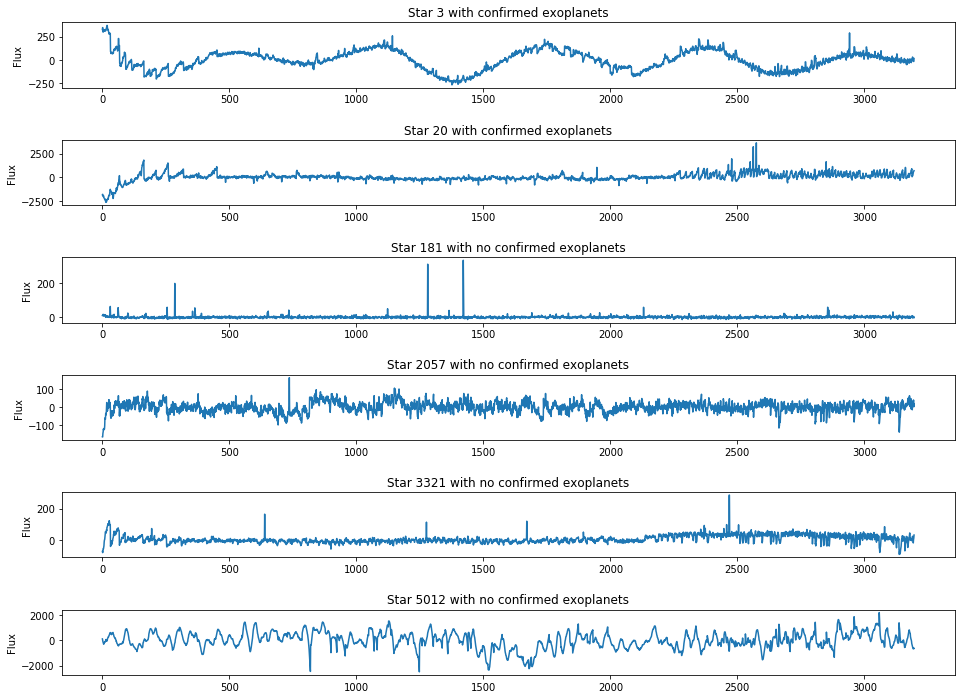

In [5]:
# Choose samples to visualise
samples = [3,20,181,2057,3321,5012]
n_samples = len(samples)


# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(samples)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(x_flux_train.iloc[samples[i]].values.tolist())
    plt.ylabel('Flux')
    title = 'Star {} with confirmed exoplanets'.format(samples[i]) if y_flux_train.iloc[samples[i]] == 2 else 'Star {} with no confirmed exoplanets'.format(samples[i])
    plt.title(title)

plt.show()

The first two time-series correspond to stars with at least one confirmed exoplanet, while the other four show the flux of stars with no confirmed exoplanets. A first observation is that the data seem to be quite noisy. Looking at the first plot, it is evident that there is some kind of periodic variation that one would expect to see in the case of a star that is orbitted by a planet. This is because as the planet moves around the star it periodically gets positioned between the star and the telescope, blocking some of the star's light and therefore resulting in a dip in measured light intensity. However, this pattern is not at all clear in the second plot, which also corresponds to a star with an exoplanet. This is a first indication of the fact that exoplanet detection is not a straightforward process, as conclusions cannot always be drawn by simply looking at the measured flux time-series. 

Let's now explore the composition of the training and test datasets: 

('Confirmed exoplanet-stars in training set: ', 37)
('Confirmed exoplanet-stars in test set: ', 5)


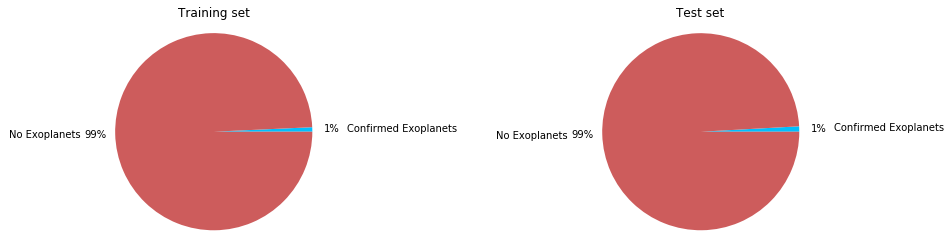

In [6]:
# Count number of exoplanet stars in the training and test datasets
n_exoplanets_train = y_flux_train[y_flux_train == 2].count()
n_exoplanets_test = y_flux_test[y_flux_test == 2].count()

print('Confirmed exoplanet-stars in training set: ', n_exoplanets_train)
print('Confirmed exoplanet-stars in test set: ', n_exoplanets_test)

# Plot pie chart for exoplanet vs non-exoplanet stars in the training and test datasets
fig = plt.figure(figsize=(16,4))
colors = ['deepskyblue','indianred']

plt.subplot(1,2,1)
plt.pie([n_exoplanets_train, y_flux_train.size-n_exoplanets_train], colors=colors, 
        labels=['Confirmed Exoplanets', 'No Exoplanets'], autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.35) 
plt.title('Training set')
plt.axis('equal')

plt.subplot(1,2,2)
plt.pie([n_exoplanets_test, y_flux_test.size-n_exoplanets_test], colors=colors, 
        labels=['Confirmed Exoplanets', 'No Exoplanets'], autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.35) 
plt.title('Test set')
plt.axis('equal')

plt.show()

The two pie charts above show that stars with confirmed exoplanets constitute only 1\% of the training and test datasets. In other words 37 out of the 5,087 training samples and 5 out of the 570 samples in the test dataset actually have an exoplanet. A class imbalance was expected even before analysing this dataset (since very few of the stars have been confirmed as having an exoplanet), but the imbalance in this dataset is found to be quite substantial. Class imbalance is a very common problem in machine learning. When one class is represented by much fewer instances than the other, most binary classification algorithms tend to have a poor performance on the minority class. In extreme cases, this may cause everything to be classified as the majority class, which is of course undesirable in this application where we are actually interested in identifying the minority of stars that have exoplanet candidates. For this reason, it was decided to try and improve the balance in the dataset by creating a new flux dataset from scratch rather than simply using the Kaggle dataset. We will do this in the next section.

---

### Custom dataset creation using K2 data

As discussed above, the exoplanet dataset that is available on Kaggle is largely imbalanced. This will most probably have a negative effect on the classification that we are aiming to perform, so we should try to create a better, more balanced dataset.

Luckily, the Kaggle dataset only includes a small subset of the data recorded by the Kepler telescope. In particular, the samples are collected primarily from Campaign 3 of the so called K2 mission. The mission has completed 20 campaigns (0-19), each of which scans a different patch of stars. In total, around 300,000 stars have been monitored to date.

The measured flux data for a large number of these stars have been analysed by astrophysicists to determine whether the stars are candidates for having one or more exoplanets or not. The NASA Exoplanet Archive provides a [database](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=k2candidates) of these candidates, with a number of features/characteristics calculated for each star based on the flux data. We will now import and explore this dataset:

In [7]:
# Load K2 candidates dataset
try:
    k2_cands = pd.read_csv("Data\k2candidates.csv",skiprows=range(149),header=1)
    print('K2 candidates dataset loaded: {} samples with {} features.'.format(*k2_cands.shape))
except:
    print('K2 candidates dataset could not be loaded.')

K2 candidates dataset loaded: 1737 samples with 147 features.


There are 1,737 objects in the list and each row comes with a set of 147 features. Let's take a peek at the candidate data:

In [8]:
k2_cands.head()

,rowid,epic_name,tm_name,epic_candname,pl_name,k2c_refdisp,k2c_reflink,k2c_disp,k2c_note,k2_campaign,...,st_bmvjlim,st_jmh2,st_jmh2err,st_jmh2lim,st_hmk2,st_hmk2err,st_hmk2lim,st_jmk2,st_jmk2err,st_jmk2lim
0,1,EPIC 201092629,2MASS J12045739-0648180,EPIC 201092629.01,K2-241 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.454,0.032,0.0,0.055,0.031,0.0,0.509,0.033,0.0
1,2,EPIC 201102594,2MASS J11592060-0631042,EPIC 201102594.01,K2-242 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.606,0.032,0.0,0.238,0.034,0.0,0.844,0.033,0.0
2,3,EPIC 201110617,2MASS J12104805-0617391,EPIC 201110617.01,K2-156 b,CONFIRMED,<a refstr=MAYO_ET_AL__2018 href=http://adsabs....,CONFIRMED,NaN,10,...,0.0,0.567,0.039,0.0,0.181,0.034,0.0,0.748,0.038,0.0
3,4,EPIC 201110617,2MASS J12104805-0617391,EPIC 201110617.01,K2-156 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.567,0.039,0.0,0.181,0.034,0.0,0.748,0.038,0.0
4,5,EPIC 201111557,2MASS J12152316-0616056,EPIC 201111557.01,NaN,CANDIDATE,<a refstr=MAYO_ET_AL__2018 href=http://adsabs....,CANDIDATE,NaN,10,...,0.0,0.482,0.033,0.0,0.171,0.030,0.0,0.653,0.030,0.0


As we can see each row has a `epic_name` column, which is the name of the target star as well as a `k2_campaign` column that indicates which K2 campaign the flux data for this particular star belongs to. Let's save these two variables in a separate dataframe to have them handy.

In [9]:
# Extract candidate star name and campaign number and store in new dataframe
k2_cand_names = k2_cands[['epic_name','k2_campaign']]
k2_cand_names.head()

,epic_name,k2_campaign
0,EPIC 201092629,10
1,EPIC 201102594,10
2,EPIC 201110617,10
3,EPIC 201110617,10
4,EPIC 201111557,10


Another important column of the imported dataset is the `k2c_disp`. This column provides the scientists' disposition on whether the candidate has been `CONFIRMED` to have an exoplanet, is a `FALSE POSITIVE` (i.e. doesn't have any exoplanets but was considered as a candidate because of some other effect such as being part of a binary star system, being affected by background objects or simply due to astrophysical stellar variability), or is still at a `CANDIDATE` status.

We will now visualise the number of objects by category and by campaign:

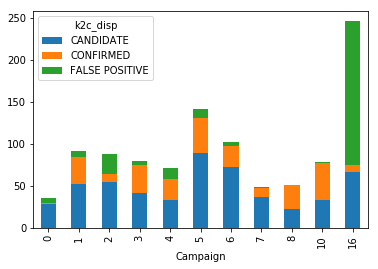

In [10]:
# Count candidates by campaign and disposition (Confirmed, Candidate or False positive)
candidates_count = k2_cands.groupby(['k2_campaign','k2c_disp'])['epic_name'].nunique()
candidates_count = pd.DataFrame(candidates_count)

# Re-index count dataframe including all combinations of k2_campaign and k2c_disp
new_index = pd.MultiIndex.from_product(candidates_count.index.levels,names=candidates_count.index.names)
candidates_count = candidates_count.reindex(new_index, fill_value=0)
candidates_count.reset_index(level=0, inplace=True)
candidates_count.reset_index(level=0, inplace=True)

# Plot stacked bar chart to visualise objects of interest by campaign
piv = candidates_count.pivot(values='epic_name', columns='k2c_disp', index='k2_campaign')
piv.plot.bar(stacked=True)
plt.xlabel('Campaign')

plt.show()

It can be seen that each campaign consists of a different number and mixture of objects. Campaign 16 has the largest number of objects - however most of them have been classified as `FALSE POSITIVES`. Campaigns 1, 3, 5 and 10 stand out for their large number of `CONFIRMED` and `CANDIDATE` objects.

The chart above has been used to decide which campaigns will be used to compile the final dataset. NASA provides the flux data for each star to the public in the form of an FITS file per target object/star. [FITS](https://en.wikipedia.org/wiki/FITS) stands for Flexible Image Transport System and is a commonly used file type in astronomy. Each campaign contains thousands of these files (the above chart only shows stars that have been classified as candidates). Due to the large size of these files, a choice had to be made with regards to which campaigns will be downloaded and used. It has been decided to use campaigns 1, 3 and 5 (the explanation for not using 10 is provided below).

A function called `flux_compiler`, which utilises the Astropy library (package for astronomy and astrophysics tasks), has been created to process the individual .fits files for a chosen campaign and return a single combined and labelled dataset. The labeling is done by searching for the name of each star in the list of candidates (`k2_cand_names`). If the name is found, the star is labelled as `1` (i.e. positive/candidate), otherwise it is labelled as `0`.  

The following piece of code runs the `flux_compiler` function for a chosen campaign. The tens of thousands of .fits files in the chosen campaign have to first be downloaded to a local folder. The files will not be provided because of the very large size, but can be downloaded from [here](https://archive.stsci.edu/pub/k2/lightcurves/tarfiles/).

**Note: the following code was run for campaigns 1,3 and 5, creating 3 separate datasets. These were then combined into a single final dataset ('flux_sample.csv'), which will be provided together with this Jupyter notebook. The following blocks of code, which have been used to obtain the final dataset are not directly relevant to the classification task and do not need to be run (in fact they shouldn't be run, because the required files are not provided due to their very large size).** 

In [ ]:
# Compile all kepler fits files for a chosen campaign into a single flux time-series dataset
from flux_load import flux_compiler
campaign = 5
flux_compiler(campaign, k2_cand_names)

Provided that the flux_compiler function has been run for each of the required campaigns, we can now load the combined flux datasets. The labels are seperated from the flux data and stored in different dataframes:

In [11]:
# Load flux datasets for each chosen campaign
try:
    flux_1 = pd.read_csv("Data\c1_lightcurves.csv")
    flux_3 = pd.read_csv("Data\c3_lightcurves.csv")
    flux_5 = pd.read_csv("Data\c5_lightcurves.csv")
    labels_1 = pd.read_csv("Data\c1_labels.csv")
    labels_3 = pd.read_csv("Data\c3_labels.csv")
    labels_5 = pd.read_csv("Data\c5_labels.csv")

    
    flux_1.columns.values[0] = "epic_name"
    flux_3.columns.values[0] = "epic_name"
    flux_5.columns.values[0] = "epic_name"
    labels_1.columns.values[0] = "epic_name"
    labels_3.columns.values[0] = "epic_name"
    labels_5.columns.values[0] = "epic_name"
    
    print('Datasets loaded successfully')
except:
    print('Datasets could not be loaded.')

Datasets loaded successfully


Unfortunately, it was observed that different stars in each campaign have time-series of different lengths. This means that we can't simply stack the flux data from each campaign one under the other and use the resulting dataset for the classification task. We will need to first edit the length of the time-series, so that it is consistent amongst all the samples. Let's have a look at some statistics regarding the lengths of the flux data in each campaign:

In [12]:
# Calculate length of time-series for each candidate ('label' = 1) in each campaign
flux_len_1 = flux_1.loc[labels_1.index[labels_1['label']==1]].count(axis=1)
flux_len_3 = flux_3.loc[labels_3.index[labels_3['label']==1]].count(axis=1)
flux_len_5 = flux_5.loc[labels_5.index[labels_5['label']==1]].count(axis=1)

In [13]:
# Time-series length statistics for each campaign
print('Campaign 1 time-series lengths:')
print('Min = {:d}'.format(flux_len_1.min()))
print('Max = {:d}'.format(flux_len_1.max()))
print('Mean = {:.0f}'.format(flux_len_1.mean()))

print('\nCampaign 3 time-series lengths:')
print('Min = {:d}'.format(flux_len_3.min()))
print('Max = {:d}'.format(flux_len_3.max()))
print('Mean = {:.0f}'.format(flux_len_3.mean()))

print('\nCampaign 5 time-series lengths:')
print('Min = {:d}'.format(flux_len_5.min()))
print('Max = {:d}'.format(flux_len_5.max()))
print('Mean = {:.0f}'.format(flux_len_5.mean()))

Campaign 1 time-series lengths:
Min = 3286
Max = 3556
Mean = 3530

Campaign 3 time-series lengths:
Min = 2984
Max = 3190
Mean = 3163

Campaign 5 time-series lengths:
Min = 3348
Max = 3457
Mean = 3437


Let's now combine the 3 campaigns' datasets into a single big dataset and calculate the same length statistics:

In [14]:
# Combine the flux series from each of the chosen campaigns
flux_raw = pd.concat([flux_1,flux_3,flux_5], ignore_index=True, sort=False)
labels = pd.concat([labels_1,labels_3,labels_5], ignore_index=True, sort=False)
print('Combined flux dataset: size {:d} x {:d}'.format(*flux_raw.shape))

Combined flux dataset: size 64254 x 3556


In [15]:
# Isolate data for all stars with exoplanet candidates in the combined dataset
exoplanet_cands = flux_raw.loc[labels.index[labels['label']==1]]

# Calculate length of time-series for each candidate ('label' = 1) in the combined dataset
cands_flux_len = exoplanet_cands.count(axis=1)-1

# Number of exoplanet candidates in the combined dataset
print('The dataset contains {:d} exoplanet candidates.'.format(len(exoplanet_cands)))

# Time-series length statistics
print('\nCombined dataset time-series lengths:')
print('Min = {:d}'.format(cands_flux_len.min()))
print('Max = {:d}'.format(cands_flux_len.max()))
print('Mean = {:.0f}'.format(cands_flux_len.mean()))

The dataset contains 303 exoplanet candidates.

Combined dataset time-series lengths:
Min = 2983
Max = 3555
Mean = 3392


It was found that the minimum flux time-series length in our data is 2,983 and the maximum is 3,555, with a mean of 3,392. However, Campaign 3 has in general a slightly lower mean of 3,163. 

There are two options to overcome the issue of different lengths. The first one is to simply try to fill or pad the smaller time-series, so that all samples will have exactly 3,555 time-series points (the maximum). This would however alter the properties of the time-series, so it is deemed unfavourable in this case. The second option is to choose an appropriate threshold/minimum length and then truncate longer time-series to this length and discard all the time-series with fewer points than the chosen minimum. Setting the threshold length to a very high value means that many samples will be discarded, so we will loose many of the datapoints/stars that we collected. On the other hand, a very small threshold length will mean that longer time-series will be truncated even more, so we may loose some useful information. In this case, the effect that we are trying to detect (i.e. the transit of planets in front of stars) is periodic and should therefore exist throughout the time-series. This means that truncating some of the series should not have a big impact on the dataset's information. 

Taking the above into consideration, it was chosen to use Campaign 3's mean length as a threshold. The flux data in campaign 10 generally have shorter lengths and were therefore discarded completely. The following blocks of code perform the truncation and discarding of samples described above:

In [16]:
# Set minimum time-series length required to keep a given sample in the dataset 
min_flux_len = int(flux_len_3.mean())+1

# Truncate flux dataset by only keeping the first min_flux_len columns
truncated_flux_raw = flux_raw[flux_raw.columns[:min_flux_len]]

In [17]:
# Find rows with missing values (i.e. samples with less than min_flux_len points in their flux time-series)
na_rows = pd.isnull(truncated_flux_raw).any(1).nonzero()[0]

# Remove rows with missing values from the flux and label sets
truncated_flux_data = truncated_flux_raw.drop(truncated_flux_raw.index[na_rows])
truncated_labels = labels.drop(labels.index[na_rows])

C:\Users\Alex\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


In [21]:
# Count number of exoplanet candidates in the truncated dataset
truncated_exoplanet_cands = truncated_flux_data.loc[truncated_labels.index[truncated_labels['label']==1]]
print('The truncated dataset has size {:d} x {:d} and contains {:d} exoplanet candidates.'.format(truncated_flux_data.shape[0],truncated_flux_data.shape[1],len(truncated_exoplanet_cands)))

The truncated dataset has size 60645 x 3163 and contains 279 exoplanet candidates.


Finally, even if we now have an improved dataset compared to the one on Kaggle, the nature of the data means that there will still be some imbalance. One way of mitigating this is through undersampling. In other words, we are going to use all the time-series of stars with exoplanet candidates (279) plus a given number of randomely selected non-exoplanet stars. This number was chosen to be 3,721, so that we end up with a final dataset of 4,000 samples:

In [14]:
import random

# Set random seed to ensure repeatability of random sample selection
random.seed(42)

# Set number of non-exoplanet stars to be included in the dataset
n_non_exoplanet = 4000-len(truncated_exoplanet_cands)

# Randomly select 'n_non_exoplanet' non-exoplanet stars to include in the dataset 
non_exoplanets_sample = random.sample(list(truncated_labels.index[truncated_labels['label']==0]),n_non_exoplanet)

# Indices of exoplanet-candidate stars and selected non-exoplanet stars
full_sample = list(truncated_labels.index[truncated_labels['label']==1]) + non_exoplanets_sample

# Extract the specified sample from the full dataset  
flux_sample = truncated_flux_data.loc[full_sample,:]
labels_sample = truncated_labels.loc[full_sample,:]

# Save flux and label sample datasets
flux_sample.to_csv("Data\\flux_sample.csv")
labels_sample.to_csv("Data\\labels_sample.csv")

---

### Dataset exploration and pre-processing

The dataset that was created was saved in two .csv files; one containing the flux values and the other one the corresponding star labels (0: no exoplanets candidates, 1: exoplanet candidates). We can now load these two files: 

In [2]:
# Load custom dataset
try:
    flux = pd.read_csv("Data/flux_sample.csv", index_col=1)
    flux.drop('Unnamed: 0', axis=1, inplace=True)
    labels = pd.read_csv("Data/labels_sample.csv",index_col=1)
    labels.drop('Unnamed: 0', axis=1, inplace=True)
    print('Dataset loaded: {} samples with {} features.'.format(*flux.shape))
except:
    print('Training dataset could not be loaded.')

Dataset loaded: 4000 samples with 3162 features.


The primary reason for creating a dataset from scratch was to obtain an improved class balance compared to the Kaggle dataset. Let's see what we have achieved:

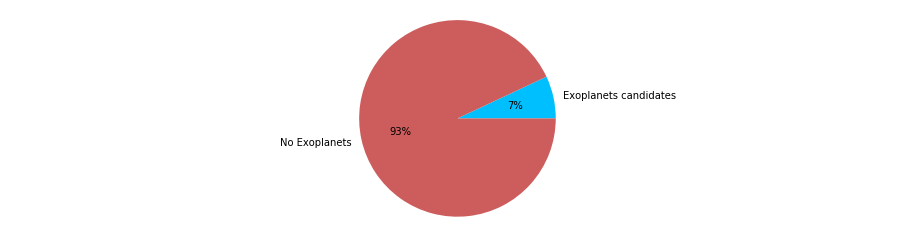

In [3]:
# Count number of exoplanet candidates in the dataset
n_candidates = labels[labels['label']==1].count()['label']

# Plot pie chart for exoplanet-candidate vs non-exoplanet stars in the training and test datasets
fig = plt.figure(figsize=(16,4))
colors = ['deepskyblue','indianred']

plt.pie([n_candidates, flux.shape[0]-n_candidates], colors=colors, 
        labels=['Exoplanets candidates', 'No Exoplanets'], autopct='%1.0f%%') 
plt.axis('equal')
plt.show()

The new dataset is still imbalanced, however the ratio of positives (stars with exoplanet candidates) and negatives (stars with no exoplanets) is considerably better. We now have 7\% of positive samples, while the Kaggle dataset only had 1\%. While definitely an improvement, the ratio is still low and other techniques will need to be employed later on to mitigate the class imbalance problem.

Let's now see what the data looks like:

In [4]:
flux.head()

,0,1,2,3,4,5,6,7,8,9,...,3152,3153,3154,3155,3156,3157,3158,3159,3160,3161
epic_name,,,,,,,,,,,,,,,,,,,,,
EPIC 201126503,671.556213,684.749084,675.719666,690.858154,691.162415,694.080627,689.405396,695.643372,708.252686,693.001953,...,690.592529,682.658630,696.794556,706.005615,701.794312,705.358887,697.711731,705.820618,696.314453,694.699280
EPIC 201155177,16629.332031,16641.957031,16602.951172,17132.261719,17137.101562,17124.759766,17143.548828,17124.330078,17136.015625,17140.457031,...,17121.007812,17114.365234,17110.667969,17117.734375,17141.994141,17120.945312,17110.550781,17129.117188,17114.902344,17121.421875
EPIC 201176672,32872.589844,32855.265625,32908.257812,32760.240234,32744.470703,32762.095703,32766.125000,32743.871094,32752.191406,32760.648438,...,32757.542969,32714.050781,32726.222656,32655.695312,32670.791016,32671.843750,32708.904297,32734.306641,32729.978516,32753.453125
EPIC 201182911,8287.248047,8292.537109,8259.041992,8246.769531,8238.206055,8234.342773,8228.845703,8226.708984,8231.898438,8221.932617,...,8183.235352,8185.875000,8218.062500,8240.030273,8245.794922,8254.473633,8261.513672,8298.529297,8291.562500,8298.814453
EPIC 201197348,11784.993164,11810.388672,11807.846680,11473.319336,11481.638672,11472.532227,11466.393555,11489.285156,11471.574219,11475.936523,...,11511.348633,11507.869141,11504.044922,11525.999023,11544.324219,11528.520508,11530.051758,11521.109375,11508.415039,11509.752930


We have a dataframe in which each row corresponds to a star with a unique `epic_name` value and has 3,162 flux time-series measurements. 

Values in different rows seem to vary widely. A pre-processing technique that is very commonly used in order to improve the performance of classification or regression algorithms is feature scaling. Its goal is to rescale the values in a dataset, preserving the differences between them. Two different feature scaling approaches will be tested: min-max normalisation, which simly rescales values in the range 0 to 1 and standardisation, which results in a set of values that has 0 mean and unit variance. The two pre-processing steps are defined below and applied to the raw flux data:

In [5]:
# Normalise (min-max) or standardise flux data
def normalise(x): 
    x_norm = (x - min(x)) / (max(x) - min(x)) 
    return x_norm

def standardise(x):
    x_std = (x-np.mean(x)) / np.std(x)
    return x_std

flux_norm = flux.apply(lambda row : normalise(row), axis = 1)
flux_std = flux.apply(lambda row : standardise(row), axis = 1)

Let's have a look at how the min-max normaliser has changed the values in the first 5 rows of the dataset:

In [6]:
flux_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,3152,3153,3154,3155,3156,3157,3158,3159,3160,3161
epic_name,,,,,,,,,,,,,,,,,,,,,
EPIC 201126503,0.050541,0.072130,0.057354,0.082127,0.082625,0.087400,0.079750,0.089958,0.110592,0.085635,...,0.081692,0.068709,0.091842,0.106915,0.100023,0.105857,0.093342,0.106612,0.091056,0.088413
EPIC 201155177,0.040426,0.059773,0.000000,0.811124,0.818540,0.799628,0.828420,0.798969,0.816876,0.823682,...,0.793878,0.783699,0.778033,0.788862,0.826038,0.793782,0.777854,0.806305,0.784522,0.794513
EPIC 201176672,0.560614,0.551761,0.578839,0.503207,0.495149,0.504155,0.506213,0.494842,0.499094,0.503415,...,0.501828,0.479605,0.485825,0.449787,0.457501,0.458039,0.476976,0.489955,0.487744,0.499739
EPIC 201182911,0.947444,0.948960,0.939359,0.935841,0.933387,0.932279,0.930704,0.930091,0.931579,0.928722,...,0.917630,0.918387,0.927613,0.933910,0.935562,0.938049,0.940067,0.950677,0.948680,0.950759
EPIC 201197348,0.698963,0.742137,0.737816,0.169096,0.183239,0.167757,0.157321,0.196239,0.166129,0.173545,...,0.233748,0.227833,0.221331,0.258655,0.289809,0.262941,0.265545,0.250342,0.228761,0.231035


As in the case of the Kaggle dataset, it will be useful to visualise the flux series for some randomely chosen samples. The flux values of 3 stars with exoplanet candidates and 3 stars without are shown below:

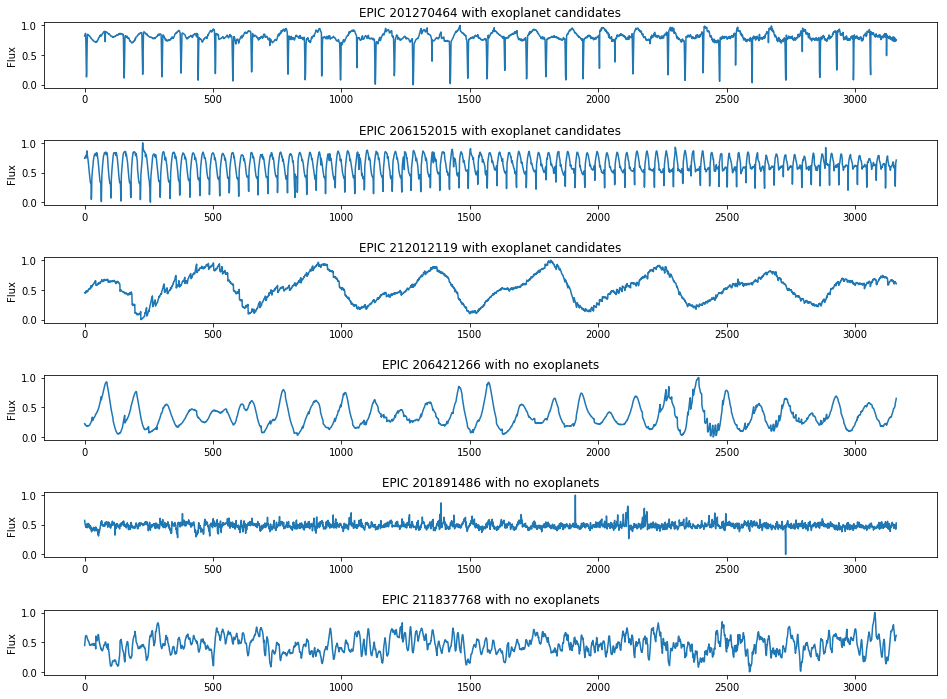

In [7]:
# Choose samples to visualise
samples = [15,120,260,693,2057,3321]
n_samples = len(samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(samples)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(flux_norm.iloc[samples[i]].values.tolist())
    plt.ylabel('Flux')
    title = '{} with exoplanet candidates'.format(labels.iloc[samples[i]].name) if labels.iloc[samples[i]].label == 1 else '{} with no exoplanets'.format(labels.iloc[samples[i]].name)
    plt.title(title)

plt.show()

It can be seen that the flux series of the 3 stars with exoplanets nicely and clearly exhibit a periodic reduction of the light intensity. However, one could argue that the 4th plot which corresponds to a non-exoplanet star also has a similar pattern.

Another observation is that the data is noisy. Noise and outliers can have a detrimental effect on the results of classification algorithms. For this reason, the first pre-processing step that we will use is what is known as data smoothing. Smoothing is commonly employed in order to improve the signal-to-noise ratio of time-series data. In simple terms, it works by passing the time-series through a filter which removes noise, outliers and other unwanted information, effectively smoothing the data. The smoothing technique that will be used is known as median filtering:

In [8]:
from scipy.signal import medfilt

# Apply median filter to the unnormalised and normalised flux data
flux_med = flux.apply(lambda row : medfilt(row), axis = 1)
flux_norm_med = flux_norm.apply(lambda row : medfilt(row), axis = 1)

The following plots show how the filtered data compare with the unfiltered, normalised time-series. It can be seen that the median filter removes many of the spikes and outliers and smoothens the signal.

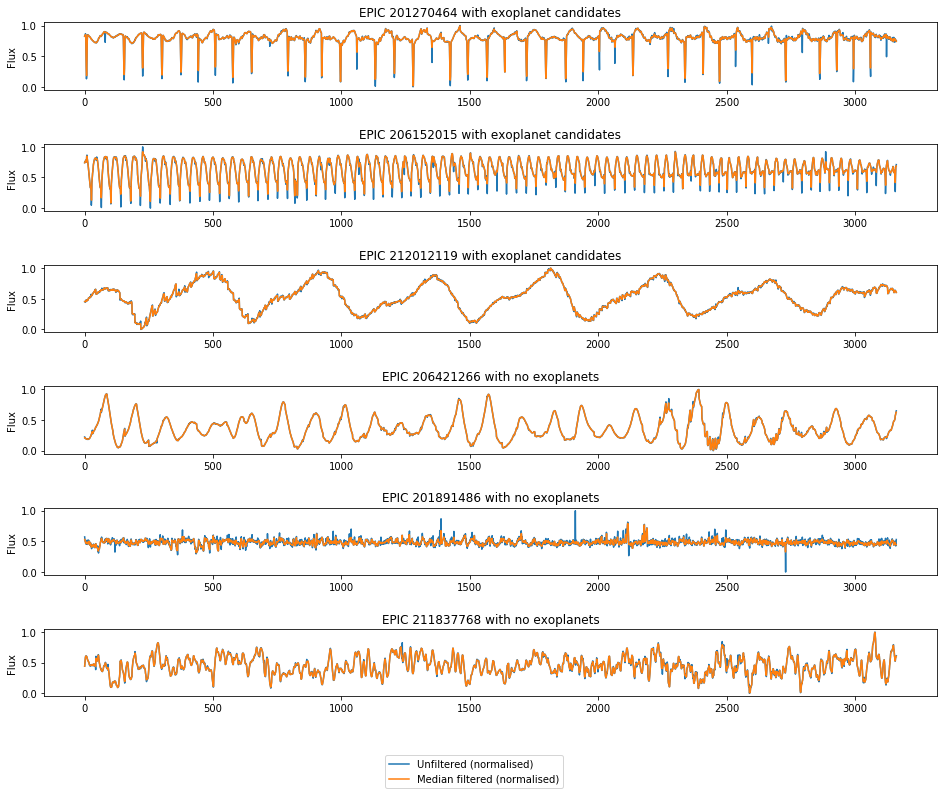

In [9]:
# Choose samples to visualise
samples = [15,120,260,693,2057,3321]
n_samples = len(samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(samples)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    ax = plt.subplot(n_samples,1,i+1)
    ax.plot(flux_norm.iloc[samples[i]].values.tolist(),label='Unfiltered (normalised)')
    ax.plot(flux_norm_med[samples[i]],label='Median filtered (normalised)')
    plt.ylabel('Flux')
    title = '{} with exoplanet candidates'.format(labels.iloc[samples[i]].name) if labels.iloc[samples[i]].label == 1 else '{} with no exoplanets'.format(labels.iloc[samples[i]].name)
    plt.title(title)

# Add legend
h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc="lower center",borderaxespad=0.1)
       
plt.subplots_adjust(bottom=0.1)    
plt.show()

### Benchmark model

At this point it would be good to define a benchmark model against which the results of the classification algorithm to be developed will be compared. The performance of this model should be measured using a suitable evaluation metric. In this particular application, we are primarily interested in detecting stars with exoplanet candidates, which as shown above are the minority class in the dataset. For this reason, accuracy would not be a very appropriate metric here (since the model can still have a very high accuracy even if it classifies everything as negative and therefore doesn't find any of the exoplanet stars). In contrast, recall is a much more important metric as it it indicates how many of the total exoplanets have been captured by the model. Another goal of the classifier is to reduce the amount of time that scientists spend to analyse the data collected by Kepler. Therefore, it will also be desirable to minimize the number of false positives that are incorrectly classified as exoplanet candidates by the model. This is measured by the precision metric. It follows that an evaluation metric that combines both precision and recall would be the most ideal for our problem. This can be obtained using a $F_{\beta}$ measure. It is important to remember that our primary goal is the detection of exoplanets and thus recall should have a greater weight than precision. Therefore, it has been decided to use a $F_{\beta}$ score with a high $\beta$ value equal to 2 as the evaluation metric for the benchmark model as well as for the final model that will be developed.

A very basic benchmarking approach would be to use a naive classifier that randomly labels samples as positive or negative. However, due to the imbalance of the dataset this would probably have very poor results. For this reason, a slightly more sophisticated but still quite simple model will have to be developed. For example, it would be interesting to determine what results one would get if he/she was to use the raw flux data provided by NASA to train a simple logistic regression classifier. Being a relatively simple and linear method, this is not expected to have spectacular results, especially when applied to the noisy and high dimensional flux time-series data. Let's see what results we get using this basic model:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, recall_score, accuracy_score

# split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(flux.values, labels.label.get_values(), 
                                                    test_size=0.25, random_state=42)

# define logistic regression model
benchmark_model = LogisticRegression(random_state=42)

# fit the model using the training data
benchmark_model = benchmark_model.fit(x_train, y_train)
    
# make prediction on test set
y_logistic = benchmark_model.predict(x_test)

# calculate performance metrics
score = fbeta_score(y_test, y_logistic, beta=2)
recall = recall_score(y_test,y_logistic)   
accuracy = accuracy_score(y_test,y_logistic)

print('Performance of benchmark model on test dataset:')
print('F-score = {:.2f}%'.format(score*100))
print('Recall = {:.2f}%'.format(recall*100))
print('Accuracy = {:.2f}%'.format(accuracy*100))

Performance of benchmark model on test dataset:
F-score = 1.42%
Recall = 1.18%
Accuracy = 90.40%


As expected, the performance of this simple approach is not satisfactory. The logistic regression classifier fails to learn the features (such as the periodic variation of flux) that make a star likely to have an exoplanet. Almost all the samples are classified as negative (the majority class) and only 1.18% of the exoplanet candidates are detected. While one could argue that these results are too poor to be used as a comparator, the approach used to obtain them is actually representative of the very first experiment that a machine learning engineer would conduct: i.e. a simple model trained using the raw, unprocessed data. Therefore, it is believed that this is a reasonable benchmark model.   

Through the pre-processing steps described above and the various techniques discussed below, we will try to surpass the results of the logistic regression algorithm and develop a much more robust and useful model.

### Feature extraction

At this stage, the data that we have for each sample is in the form of time-series of 3,162 values. The question now is how can we use this kind of information to train a classification algorithm. One option is to just feed these processed time-series to our predictor and hope that it will manage to learn the key features that distinguish the flux of an exoplanet star from that of a non-exoplanet star. Of course, in this case the temporal relationship between the 3,162 variables is very important and therefore we would want our predictor to be able to learn the time structures in the data.

Another option, which will be explored here, is to try to extract a much finer set of key features that characterise the time-series. For example, some of the basic characteristics of a time-series are statistical measures such as the mean, maximum, minimum, variance, median, etc. of its values. Ideally, we would want to be able to extract features that are relevant and important for the particular case. This of course requires some domain knowledge. Luckily, there is a python library called Feature Analysis for Time Series (FATS), which was developed with a primary focus on analysing and extracting features from astronomical time-series and in particular light-curve data! The documentation for the package can be found [here](http://isadoranun.github.io/tsfeat/FeaturesDocumentation.html).

The FATS package makes it possible to extract a number of features that are actually used by researchers to analyse and classify light curves. As explained in the documentation, the number of features that can be extracted depends on the variables in the dataset. Our dataset only has one variable - the magnitude of the light-curve - which allows us to extract 22 features, including some common statistics and some more advanced measures. The names of the features are shown in the DataFrame created below (column names) and a description of each of them can be find in the FATS documentation.

*Note that the FATS package is only supported in Python 2*

In [10]:
import FATS

# Obtain list of features that can be calculated using only the flux magnitude of a star's light-curve
feature_list = FATS.FeatureSpace(Data=['magnitude'])

The code below is used to extract the aforementioned features from the flux time-series dataset using the FATS package. It will be applied to the median filtered flux data derived above.

*note: the following code does not need to be run as the flux_med_features_FATS has already been created and included in the "Data" folder*

In [11]:
# Empty array to save extracted features
features = []

# Calculate time-series features for each median filtered flux using FATS 
for i in range(0,len(flux_med)):
    x = np.array([flux_med[i]])
    features_=feature_list.calculateFeature(x)
    features.append(features_.result(method='array'))
    
# Save to dataframe
features = pd.DataFrame(features,index=flux.index.values, columns=features_.result(method='features'))

# Save to csv file
save_path = "Data\\flux_med_features_FATS.csv"
features.to_csv(save_path)

The 22 features were extracted and saved to a csv file. These can now be loaded, avoiding having to re-run the time-consuming feature extraction process. 

In [10]:
# Load features extracted from median filtered flux data
try:
    flux_med_features = pd.read_csv("Data\\flux_med_features_FATS.csv", index_col=0)
    print('Extracted med_features loaded: {} samples with {} features.'.format(*flux_med_features.shape))
except:
    print('Extracted med_features could not be loaded.')

Extracted med_features loaded: 4000 samples with 22 features.


Let's see what the feature datasets look like:

In [11]:
flux_med_features.head()

,Amplitude,AndersonDarling,Autocor_length,Con,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,FluxPercentileRatioMid80,Gskew,...,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,PercentDifferenceFluxPercentile,Q31,Rcs,Skew,SmallKurtosis,Std
EPIC 201126503,20.043335,1.0,6.0,0.009177,0.161134,0.281052,0.404542,0.570978,0.791195,-3.514435,...,7.108185,0.661290,-0.166667,0.096059,0.050839,14.067642,0.211896,0.150498,1.402287,10.826865
EPIC 201155177,47.752930,1.0,131.0,0.014241,0.184466,0.327884,0.475660,0.630874,0.814041,-11.155273,...,19.278320,0.977546,-0.433333,0.029266,0.004736,38.576660,0.191963,-4.334019,68.535031,30.065129
EPIC 201176672,80.014648,1.0,8.0,0.011709,0.170207,0.287813,0.407513,0.546558,0.770174,1.988281,...,26.572266,0.981025,-0.300000,0.029882,0.003985,53.156250,0.100251,-7.575988,98.888210,67.382097
EPIC 201182911,1085.543213,1.0,2.0,0.013608,0.065607,0.117769,0.169970,0.204334,0.249108,-2171.588867,...,92.334473,0.930108,-0.100000,0.342142,0.135799,190.279785,0.029618,-3.978991,15.937945,461.285017
EPIC 201197348,46.842285,1.0,7.0,0.017722,0.143997,0.249128,0.374509,0.536093,0.748027,-17.596191,...,14.297852,0.933270,-0.300000,0.025076,0.006585,28.386230,0.165966,0.438616,15.269190,26.129237


Once again, it's hard to get any meaningful insight by just looking at the values. One thing that may help is plotting some density histograms to visualise the distribution of values of each feature for exoplanet and non-exoplanet stars.

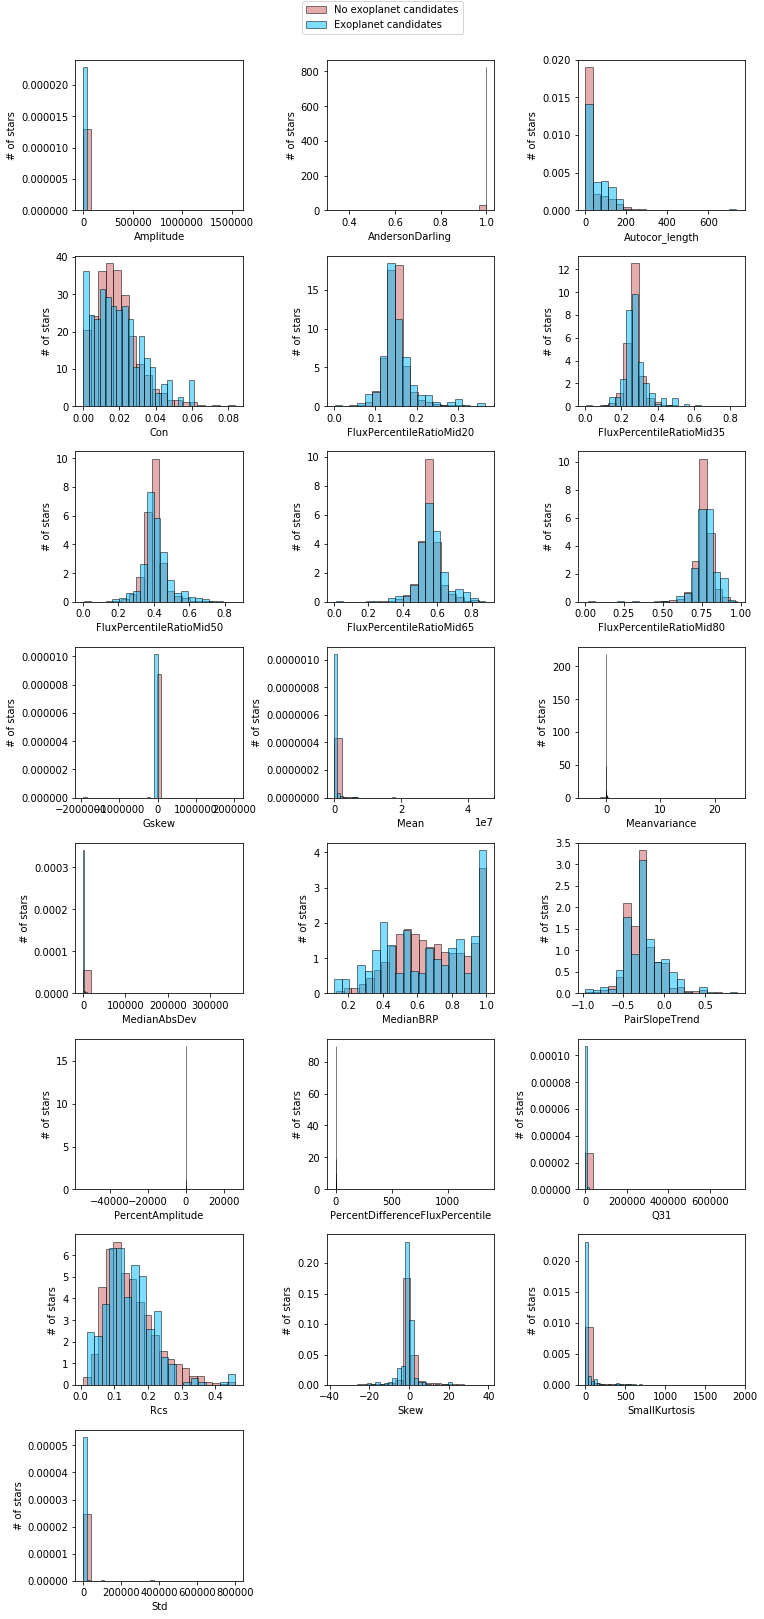

In [12]:
# number of stars with exoplanet candidates
n_exoplanet = labels.label.sum()

# set up figure
fig = plt.figure(figsize=(12,25))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.3)

# plot histogram for each features
for i,feature in enumerate(flux_med_features.columns.values):
    ax = fig.add_subplot(8,3,i+1)
    
    pos_feature = flux_med_features[feature].iloc[:n_exoplanet].values
    neg_feature = flux_med_features[feature].iloc[n_exoplanet:].values
    
    ax.hist(neg_feature,alpha=0.5,bins=20,color='indianred',edgecolor='black',density=True,label='No exoplanet candidates')
    ax.hist(pos_feature,alpha=0.5,bins=20,color='deepskyblue',edgecolor='black',density=True,label='Exoplanet candidates')

    ax.set_xlabel(feature)
    ax.set_ylabel('# of stars')   

# Add legend
h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc="upper center",borderaxespad=0.1)
    
plt.subplots_adjust(top=0.97)
plt.show()

It is still hard to identify any potential trends or differencies between the positive and negative samples' features. A better understanding of the domain and data would clearly help. However, from a first sight at the distributions, it looks like some features like `Autocor_length`, `Con`, `Gskew`, `MedianBRP`, `SmallKurtosis` and `Std` may be particularly important in distinguishing stars that have exoplanets from those that don't.

#### Normalisation/Standardisation of extracted sets of features

By observing the extracted features, we can see that there is a large variation in the ranges of their values. This can have a significant negative effect on the performance of some machine learning algorithms. We can avoid this using feature scaling. In particular min-max normalisation and standardisation will be applied separately on each of the 22 extracted flux features. The resulting, rescaled datasets will then both  be used to train a set of different algorithms in order to determine which one leads to the greatest performance improvement, compared to using the unscaled features' values.

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
min_max_scaler = MinMaxScaler() #set up min-max scaler
std_scaler = StandardScaler() #set up standard scaler

# normalise and standardise the extracted features
flux_med_features_norm = min_max_scaler.fit_transform(flux_med_features.values)
flux_med_features_std = std_scaler.fit_transform(flux_med_features.values)

---

### Classification using extracted features

In [14]:
# Suppress warnings temporarily
import warnings
warnings.filterwarnings("ignore")

##### Spot-checking various algorithms

Firstly, we will create an algorithm spot-checking pipeline in order to test a number of supervised learning algorithms, compare their results and determine the most suitable one for this problem:

In [15]:
# Algorithm spot-check
from sklearn.metrics import fbeta_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def predictor(classifier, X, y, test_size=0.25, beta=2, oversample=0):
    
    # split dataset into training and test subsets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # resample training dataset using SMOTE
    if oversample>0:
        sm = SMOTE(sampling_strategy=oversample,random_state=42)
        x_train, y_train = sm.fit_resample(x_train, y_train)
        
    # fit the model using the training data
    model = classifier.fit(x_train, y_train)
    
    # make prediction on first 500 samples of training set
    y_pred_train = model.predict(x_train[:500])
    
    # make prediction on test set
    y_pred_test = model.predict(x_test)
    
    # calculate f-score, recall and accuracy on training and test set
    score_train = fbeta_score(y_train[:500], y_pred_train, beta)
    score_test = fbeta_score(y_test, y_pred_test, beta)
    
    recall_train = recall_score(y_train[:500],y_pred_train)
    recall_test = recall_score(y_test,y_pred_test)
    
    accuracy_train = accuracy_score(y_train[:500],y_pred_train)
    accuracy_test = accuracy_score(y_test,y_pred_test)
    
    fscore = [score_train,score_test]
    recall = [recall_train,recall_test]
    accuracy = [accuracy_train,accuracy_test]
        
    return fscore, recall, accuracy, y_pred_test, y_pred_train

The classification models to be tested will be saved in a dictionary. It will include the following algorithms: 
* Logistic regression classifier
* Decistion tree
* Linear SVM
* Cubic SVM
* RBF SVM (with a set of different C values)
* Naive Bayes classifier
* Bagging
* Random Forest
* Gradient Boosting 
* AdaBoost

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

# Dictionary containing all classification models to be tested
models = dict()

models['Logistic'] = LogisticRegression(class_weight='balanced', random_state=42)
models['Decision Tree'] = DecisionTreeClassifier(class_weight='balanced', random_state=42)
models['Linear SVM'] = SVC(kernel='linear', class_weight='balanced', random_state=42)
models['Cubic SVM'] = SVC(kernel='poly', class_weight='balanced', random_state=42)
for c in np.arange(0.1, 1.1, 0.1):
    models['RBF SVM (C = '+str(c)+')'] = SVC(C=c, class_weight='balanced', random_state=42)
models['Naive Bayes'] = GaussianNB()
models['Bagging'] = BaggingClassifier(n_estimators=50 ,random_state=42)
models['Random Forest'] = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
models['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=50 ,random_state=42)
models['AdaBoost'] = AdaBoostClassifier(n_estimators=50 ,random_state=42)

Let's now test all the algorithms in `models` using the pipeline defined above and record their results:

In [17]:
x = flux_med_features_norm
y = labels.label.get_values()

scores = []
recalls = []
accuracies = []

for model in models:
    
    score, recall, accuracy, y_pred_test, y_pred_train = predictor(models[model], x, y, oversample=1)
    
    scores.append(score[1])
    recalls.append(recall[1])
    accuracies.append(recall[1])
    
    print(model)
    print('\nTraining set')
    print('F-score = {:.2f}%'.format(score[0]*100))
    print('Recall = {:.2f}%'.format(recall[0]*100))
    print('Accuracy = {:.2f}%'.format(accuracy[0]*100))
    print('\nTest set')
    print('F-score = {:.2f}%'.format(score[1]*100))
    print('Recall = {:.2f}%'.format(recall[1]*100))
    print('Accuracy = {:.2f}%'.format(accuracy[1]*100))
    print('----------------------------------------------')

Bagging

Training set
F-score = 100.00%
Recall = 100.00%
Accuracy = 100.00%

Test set
F-score = 19.19%
Recall = 20.00%
Accuracy = 84.60%
----------------------------------------------
RBF SVM (C = 0.9)

Training set
F-score = 35.06%
Recall = 63.89%
Accuracy = 65.20%

Test set
F-score = 30.65%
Recall = 52.94%
Accuracy = 61.10%
----------------------------------------------
RBF SVM (C = 0.4)

Training set
F-score = 34.59%
Recall = 61.11%
Accuracy = 66.80%

Test set
F-score = 26.76%
Recall = 44.71%
Accuracy = 62.10%
----------------------------------------------
RBF SVM (C = 0.7000000000000001)

Training set
F-score = 36.28%
Recall = 63.89%
Accuracy = 67.40%

Test set
F-score = 30.68%
Recall = 51.76%
Accuracy = 62.60%
----------------------------------------------
RBF SVM (C = 0.5)

Training set
F-score = 37.74%
Recall = 66.67%
Accuracy = 67.60%

Test set
F-score = 29.37%
Recall = 48.24%
Accuracy = 63.90%
----------------------------------------------
Decision Tree

Training set
F-score =

In [18]:
print('Max F-score using {}: {:.2f}%'.format(list(models)[np.argmax(scores)],max(scores)*100))

Max F-score using Gradient Boosting: 39.47%


The Gradient Boosting algorithm is found to have the best performance on the flux test set. For this reason, we will choose this algorithm and try to refine it in the following section.

#####  Refinement - GridSearch

Gradient Boosting's hyperparameters will now be tuned using grid search. Grid search is a technique used to perform an exhaustive search in the hyperparameter space in order to find the set of parameters that maximise a specified performance metric. In this case, the evaluation metric was chosen to be the $F_2$ score, which as explained above is a suitable metric for this application.

In [19]:
# Define x (data) and y (labels) to be used in the model refinement process
x = flux_med_features_norm
y = labels

Refining the Gradient Boosting algorithm is not straightforward because there is a large set of hyperparameters that need to be tuned. In particular, Gradient Boosting has a number of boosting related parameters as well as a number of decision tree/weak-learner related parameters. The approach used to overcome this problem was splitting the grid search process into several steps.

Firstly, we will tune the boosting related parameters `learning_rate` and `n_estimators`, using the default values for all the other hyperparameters. The former dictates how big the steps towards the direction of the descending gradient are and the latter determines the number of weak learners used.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score
from imblearn.pipeline import Pipeline

# Initialize imblearn pipeline with chosen unoptimized classifier.
# note: using a pipeline rather than just a classifier makes it possible to use SMOTE to over-sample the training set used in the Grid Search
model = Pipeline([('oversample', SMOTE(sampling_strategy=1,random_state=42)),('clf', GradientBoostingClassifier(random_state=42))])

# Parameters to be tuned
params = {'clf__learning_rate':[0.0001, 0.001, 0.01, 0.1, 1], 'clf__n_estimators':[20, 50, 100, 200, 300, 400, 500]}

# Make an fbeta_score scorer
scorer = make_scorer(fbeta_score,beta=2)

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer, n_jobs=-1, verbose = 5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid.fit(x_train,y_train)

# Get the optimised estimator
best_model = grid_fit.best_estimator_

# Make predictions using the unoptimised and optimised model
predictions = (model.fit(x_train, y_train)).predict(x_test)
best_predictions = best_model.predict(x_test)

# Report the before-and-afterscores
print('Unoptimised model\n------------')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2)*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions)*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

print('\nOptimised Model\n------------')
print('Final F-score on the test data: {:.2f}%'.format(fbeta_score(y_test, best_predictions, beta = 2)*100))
print('Final recall on the test data: {:.2f}%'.format(recall_score(y_test, best_predictions)*100))
print('Final accuracy score on the test data: {:.2f}%'.format(accuracy_score(y_test, best_predictions)*100))

print('\nOptimal parameters:')
print(grid_fit.best_params_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  3.1min finished


Unoptimised model
------------
F-score on test data: 32.19%
Recall on test data: 37.65%
Accuracy score on test data: 82.20%

Optimised Model
------------
Final F-score on the test data: 44.03%
Final recall on the test data: 69.41%
Final accuracy score on the test data: 70.30%

Optimal parameters:
{'clf__learning_rate': 0.1, 'clf__n_estimators': 20}


The best $F_2$ score was obtained using `learning_rate`=0.1 and `n_estimators`=20. This number of trees is relatively small, but will be kept for now.

Fixing the two hyperparameters at these values, the next step will be to optimise the decision tree related hyperparameters `max_depth` and  `min_samples_split`, using a new grid search:

In [22]:
# Parameters to be tuned
params = {'clf__learning_rate':[0.1], 'clf__n_estimators':[20], 'clf__max_depth':range(3,20,2), 'clf__min_samples_split':range(2,201,25)}

# Make an fbeta_score scorer
scorer = make_scorer(fbeta_score,beta=2)

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer, n_jobs=-1, verbose = 5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid.fit(x_train,y_train)

# Get the optimised estimator
best_model = grid_fit.best_estimator_

# Make predictions using the unoptimised and optimised model
predictions = (model.fit(x_train, y_train)).predict(x_test)
best_predictions = best_model.predict(x_test)

# Report the before-and-afterscores
print('Unoptimised model\n------------')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2)*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions)*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

print('\nOptimised Model\n------------')
print('Final F-score on the test data: {:.2f}%'.format(fbeta_score(y_test, best_predictions, beta = 2)*100))
print('Final recall on the test data: {:.2f}%'.format(recall_score(y_test, best_predictions)*100))
print('Final accuracy score on the test data: {:.2f}%'.format(accuracy_score(y_test, best_predictions)*100))

print('\nOptimal parameters:')
print(grid_fit.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.3min finished


Unoptimised model
------------
F-score on test data: 32.19%
Recall on test data: 37.65%
Accuracy score on test data: 82.20%

Optimised Model
------------
Final F-score on the test data: 44.03%
Final recall on the test data: 69.41%
Final accuracy score on the test data: 70.30%

Optimal parameters:
{'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__n_estimators': 20, 'clf__min_samples_split': 2}


It is found that the optimal value of `max_depth` is 3 and that of `min_samples_split` is 2, which are the default values provided by Scikit-learn. 

Fixing these two parameters, a grid search was then performed to tune `min_samples_leaf`:

In [23]:
# Parameters to be tuned
params = {'clf__learning_rate':[0.1], 'clf__n_estimators':[20], 'clf__max_depth':[3], 'clf__min_samples_split':[2],
          'clf__min_samples_leaf':range(1,82,5)}
# Make an fbeta_score scorer
scorer = make_scorer(fbeta_score,beta=2)

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer, n_jobs=-1, verbose = 5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid.fit(x_train,y_train)

# Get the estimator
best_model = grid_fit.best_estimator_

# Make predictions using the unoptimised and optimised model
predictions = (model.fit(x_train, y_train)).predict(x_test)
best_predictions = best_model.predict(x_test)

# Report the before-and-afterscores
print('Unoptimised model\n------------')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2)*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions)*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

print('\nOptimised Model\n------------')
print('Final F-score on the test data: {:.2f}%'.format(fbeta_score(y_test, best_predictions, beta = 2)*100))
print('Final recall on the test data: {:.2f}%'.format(recall_score(y_test, best_predictions)*100))
print('Final accuracy score on the test data: {:.2f}%'.format(accuracy_score(y_test, best_predictions)*100))

print('\nOptimal parameters:')
print(grid_fit.best_params_)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   10.1s finished


Unoptimised model
------------
F-score on test data: 32.19%
Recall on test data: 37.65%
Accuracy score on test data: 82.20%

Optimised Model
------------
Final F-score on the test data: 44.12%
Final recall on the test data: 70.59%
Final accuracy score on the test data: 69.50%

Optimal parameters:
{'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__min_samples_leaf': 61, 'clf__min_samples_split': 2, 'clf__n_estimators': 20}


The optimal value of `min_samples_leaf` is found to be 61, which can be rounded to 60.

Finally, after fixing the value of this parameter, a last grid search will be used in order to tune the `max_features` parameter:

In [24]:
# Parameters to be tuned
params = {'clf__learning_rate':[0.1], 'clf__n_estimators':[20], 'clf__max_depth':[3], 'clf__min_samples_split':[2],
          'clf__min_samples_leaf':[60], 'clf__max_features':range(4,24,2)}
# Make an fbeta_score scorer
scorer = make_scorer(fbeta_score,beta=2)

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=model, param_grid=params, cv=10, scoring=scorer, n_jobs=-1, verbose = 5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid.fit(x_train,y_train)

# Get the optimised estimator
best_model = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
predictions = (model.fit(x_train, y_train)).predict(x_test)
best_predictions = best_model.predict(x_test)

# Report the before-and-afterscores
print('Unoptimised model\n------------')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2)*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions)*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

print('\nOptimised Model\n------------')
print('Final F-score on the test data: {:.2f}%'.format(fbeta_score(y_test, best_predictions, beta = 2)*100))
print('Final recall on the test data: {:.2f}%'.format(recall_score(y_test, best_predictions)*100))
print('Final accuracy score on the test data: {:.2f}%'.format(accuracy_score(y_test, best_predictions)*100))

print('\nOptimal parameters:')
print(grid_fit.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished


Unoptimised model
------------
F-score on test data: 32.19%
Recall on test data: 37.65%
Accuracy score on test data: 82.20%

Optimised Model
------------
Final F-score on the test data: 44.54%
Final recall on the test data: 72.94%
Final accuracy score on the test data: 68.30%

Optimal parameters:
{'clf__n_estimators': 20, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__min_samples_leaf': 60, 'clf__max_features': 10, 'clf__min_samples_split': 2}


The optimal value of `max_features` was found to be 10.

It has been found that using lower `learning_rate` values results in better robustness and generalisation of the model. Therefore, we will now try to train the Gradient Boosting model using the optimal decision tree hyperparameters found above, but reducing the learning rate. At the same time, the number of weak learners, `n_estimators`, will be increased proportionally to the reduction of the learning rate. This procedure was repeated a number of times with:
* `learning_rate`=0.01, `n_estimators` = 200
* `learning_rate`=0.005, `n_estimators` = 400
* `learning_rate`=0.001, `n_estimators` = 2000

The final model is trained and tested below:

In [25]:
# Define Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.001, max_depth=3,
                                   min_samples_split=2,min_samples_leaf=60,max_features=10,random_state=42)

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# resample training dataset using SMOTE
sm = SMOTE(sampling_strategy=1,random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)
        
# Fit the grid search object to the training data and find the optimal parameters using fit()
model = model.fit(x_train,y_train)

# Make predictions using the trained model
predictions = (model.fit(x_train, y_train)).predict(x_test)

# Report the scores
print('\nOptimised Model\n------------')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2)*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions)*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))


Optimised Model
------------
F-score on test data: 44.54%
Recall on test data: 72.94%
Accuracy score on test data: 68.30%


##### Results exploration

Let's try to get a better understanding of these results. To this end, it would be useful to visualise some cases where the model does well and some where its predictions are incorrect. The indices (star names) of the samples in the test corresponding to the True Positives (TP), False Positives (FP), True Negatives (TN) and False Negatives (FN) are found below: 

In [24]:
TP = y_test.iloc[np.where((predictions==1)&(y_test.label.get_values()==1))[0]].index #indices of true positives
FP = y_test.iloc[np.where((predictions==1)&(y_test.label.get_values()==0))[0]].index #indices of false positives
TN = y_test.iloc[np.where((predictions==0)&(y_test.label.get_values()==0))[0]].index #indices of true negatives
FN = y_test.iloc[np.where((predictions==0)&(y_test.label.get_values()==1))[0]].index #indices of false negatives

First, let's view the flux time-series of 3 stars which were correctly classified by the Gradient Boosting model as having exoplanets (or exoplanet candidates). It can be seen that in all three cases there is a periodic reduction of the flux, caused by the transiting exoplanet. This characteristic is less clear/obvious in some cases than in others, but the classifier seems to have been able to identify it.

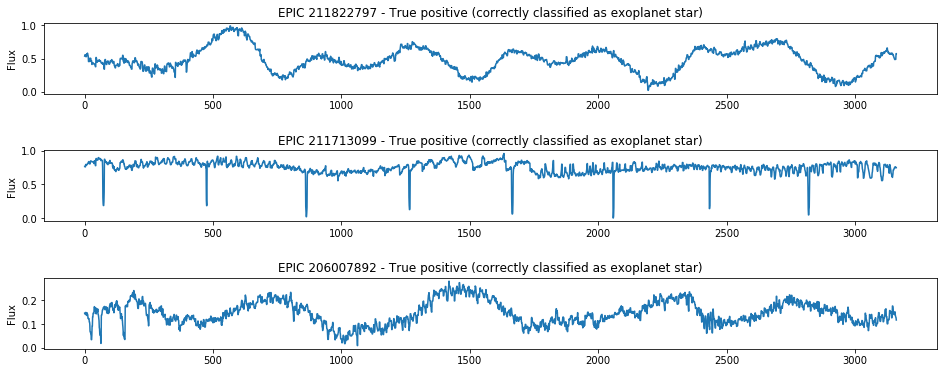

In [27]:
# Randomely select TP samples to visualise
n_samples = 3
TP_rand = np.random.randint(0,len(TP),n_samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(TP_rand)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(flux_norm_med.loc[TP[TP_rand[i]]])
    plt.ylabel('Flux')
    title = '{} - True positive (correctly classified as exoplanet star)'.format(TP[TP_rand[i]])
    plt.title(title)

plt.show()

Next, let's visualise some of the stars that have been incorrectly classified as positives. The relatively high number of false positives is the main reason why the $F_2$ score that was obtained is not very high, as it results in a low precision. Therefore it is important to try to understand why the algorithm thinks that these non-exoplanet stars may have an exoplanet.

By looking at the plots of the three randomly selected false positive samples, it can be seen that some of them do actually exhibit a similar pattern as the true positives found above. In particular, the first two time-series (primarily the first one) have a number of regular drops of flux. In contrast, such as a pattern is not apparent in the third plot, which is however distorted by a large spike that has not been removed by the median filter.

It should be reminded here that the "true" labels for each of the time-series were obtained by checking whether the corresponding stars are included in NASA's "K2 candidates" table. This is a list of all the stars that have been checked by astronomers and were considered to be candidates for exoplanet stars. However, not all of the thousands of stars monitored by the Kepler telescope have been assessed yet. Hence, it is possible that the some stars in our dataset which may be orbitted by an exoplanet are not included in the K2 table and have thus been labelled as negatives or 0. For this reason, it is believed that some of the false positives (like the ones displayed below) may actually have exoplanet candidates, but they just haven't been manually classified yet by scientists. This means that some of them may actually be true positives, which would then mean that our classifier may have discovered some new exoplanet candidates!

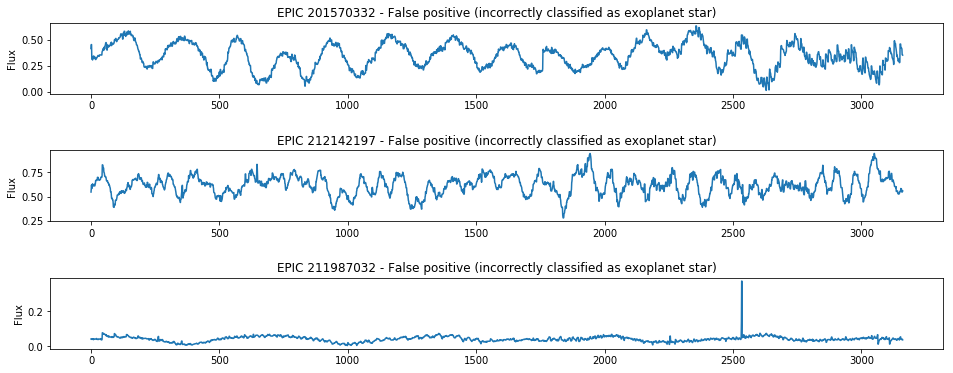

In [47]:
# Randomely select FP samples to visualise
n_samples = 3
FP_rand = np.random.randint(0,len(FP),n_samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(FP_rand)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(flux_norm_med.loc[FP[FP_rand[i]]])
    plt.ylabel('Flux')
    title = '{} - False positive (incorrectly classified as exoplanet star)'.format(FP[FP_rand[i]])
    plt.title(title)

plt.show()

Let's now have a look at some of the true negatives - i.e. the stars that have no exoplanets and were correctly classified by the supervised learning model. The three time-series shown below do not exhibit any periodic flux reduction pattern, that would be expected from a star with exoplanets. The Gradient Boosting model seems to have been able to understand this and correctly classify the stars as negatives. In fact, the classifier found many of the exoplanets while also classifying the majority of the non-exoplanet stars correctly, which is a very good result. 

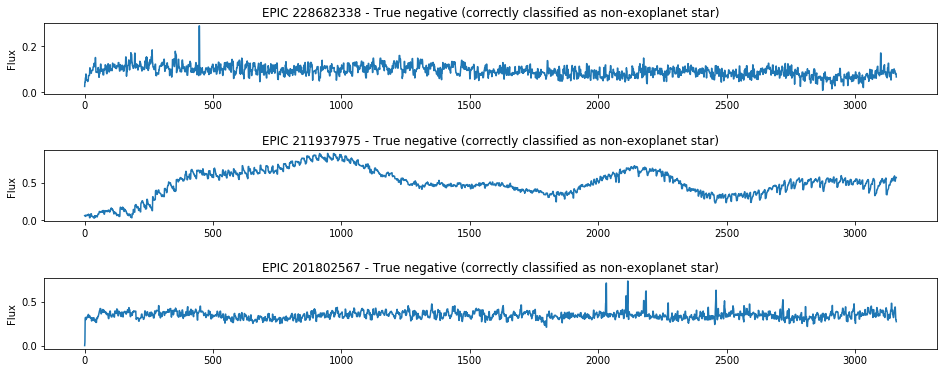

In [34]:
# Randomely select FP samples to visualise
n_samples = 3
TN_rand = np.random.randint(0,len(TN),n_samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(TN_rand)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(flux_norm_med.loc[TN[TN_rand[i]]])
    plt.ylabel('Flux')
    title = '{} - True negative (correctly classified as non-exoplanet star)'.format(TN[TN_rand[i]])
    plt.title(title)

plt.show()

Finally, let's examine some of the few cases where the classifier incorrectly predicts that a star does not have an exoplanet candidate, while scientist have found that it does. As it can be observed from the three plots below, these are cases where there are no clear periodic dimming patterns. Moreover, all three cases shown below have a lot of noise. It looks like this has not allowed the algorithm to discover the exoplanets that _may_ be orbiting these stars. It is important to note that the "K2 candidates" table also includes a number of false positives (i.e. stars that were initially considered to be candidates for exoplanets, but were then labelled as `FALSE POSITIVE`). Therefore, some of the samples that our model classified as false negatives may actually be true negatives. In fact, the first star shown below (EPIC 206065006) is classified as a false positive in the K2 table, which means that the classification of our Gradient Boosting model is actually correct.

One possible future improvement would be to only assign positive labels to the stars that are classified as `CONFIRMED` or `CANDIDATE` in the "K2 candidates" table, rather than also including the `FALSE POSITIVE` ones. This would most probably lead to even better classification results.

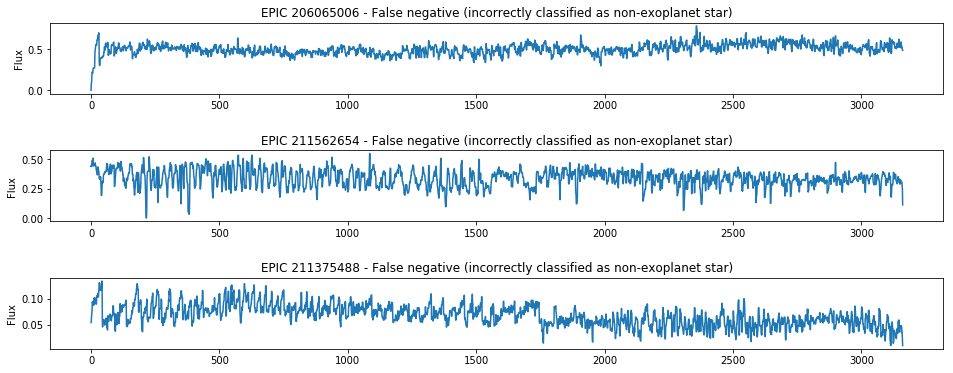

In [40]:
# Randomely select FP samples to visualise
n_samples = 3
FN_rand = np.random.randint(0,len(FN),n_samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(FN_rand)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(flux_norm_med.loc[FN[FN_rand[i]]])
    plt.ylabel('Flux')
    title = '{} - False negative (incorrectly classified as non-exoplanet star)'.format(FN[FN_rand[i]])
    plt.title(title)

plt.show()

##### Model validation

Finally, a sensitivity check should be performed in order to ensure that the model is adequately robust. One way of doing this is by perturbing the training dataset slightly and observing the effect that this has on the performance of the model.

A simple way of achieving this perturbation is by tweaking the `random_state` parameter of the `train_test_split` and `SMOTE` algorithms. This will change the mix of samples in the training and test datasets, as well as the results of over-sampling on the training set. A `random_state` of 42 has been used so far. Let's now change this to 1 and 200:

In [26]:
# Define Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.001, max_depth=3,
                                   min_samples_split=2,min_samples_leaf=60,max_features=10,random_state=42)

# Split dataset into training and test subsets using different random_state
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

# Resample training dataset using SMOTE and different random_state
sm = SMOTE(sampling_strategy=1,random_state=1)
x_train, y_train = sm.fit_resample(x_train, y_train)
        
# Fit the grid search object to the training data and find the optimal parameters using fit()
model = model.fit(x_train,y_train)

# Make predictions using the trained model
predictions = (model.fit(x_train, y_train)).predict(x_test)

# Report the scores
print('Results using random seed of 1:')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2)*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions)*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

Results using random seed of 1:
F-score on test data: 41.94%
Recall on test data: 74.29%
Accuracy score on test data: 69.40%


In [27]:
# Define Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.001, max_depth=3,
                                   min_samples_split=2,min_samples_leaf=60,max_features=10,random_state=42)

# Split dataset into training and test subsets using different random_state
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=200)

# Resample training dataset using SMOTE and different random_state
sm = SMOTE(sampling_strategy=1,random_state=200)
x_train, y_train = sm.fit_resample(x_train, y_train)
        
# Fit the grid search object to the training data and find the optimal parameters using fit()
model = model.fit(x_train,y_train)

# Make predictions using the trained model
predictions = (model.fit(x_train, y_train)).predict(x_test)

# Report the scores
print('Results using random seed of 200:')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2)*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions)*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

Results using random seed of 200:
F-score on test data: 44.58%
Recall on test data: 68.97%
Accuracy score on test data: 70.80%


In both cases, the results are not very different to the ones obtained using a `random_state` of 42. Therefore, it is concluded that the model is robust.

### Conclusion

In conclusion, a Gradient Boosting model was created that performs significantly better than the logistic regression model used as a benchmark. The recall score on the test set was found to be equal to 72.94%. This is a particularly good result, as it means that the majority of exoplanets in the test set are detected. Of course it is not ideal, since there is about one quarter of potential exoplanet candidates that are not found by the model. This is definitely one area for improvement, as we would ideally want to find all the exoplanets or exoplanet candidates. Moreover, the model also correctly classified most of the non-exoplanet stars. It is likely that the model also detected a number of new exoplanet candidates, which astrophysicists may have not found yet. This would be considered a very fulfilling achievement, given the limited time in which this solution was developed.

An idea for future improvement would be to try to develop a deep learning algorithm that is trained directly using the time-series data. A well designed neural network architecture may be able to automatically detect the features that are most relevant and then use these for the classification of the time-series, rather than relying on a separate feature extraction step performed prior to training. Convolutional neural networks (CNN), in particular, are likely to be suitable for this application, given their good performance with spatial and temporal data. Moreover, another category of neural networks that could be explored are long short-term memory (LSTM) networks, which have been found to produce good results in classification problems involving time-series data.